In [1]:
#importing some useful packages
import pickle
import cv2
import math
import time
import h5py
import json
import os
import csv
import random
import numpy as np
import pandas as pd
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import theano
%matplotlib inline

Using TensorFlow backend.


10423
12
<class 'numpy.ndarray'>
(20634,)
(20634,)


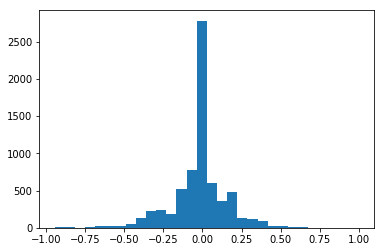

In [13]:
df = pd.read_csv('driving_log_Arun.csv')
print(len(df))
#if (df['center'].values[0][16:18] == '12'):
#    print ('yes')
#print(df[df['center'].values[0][16:18] == '12'])
df = df.drop(df[df['steering'] == 0].sample(frac=0.60).index)
#repeat = 4
#df = pd.concat(df[df['center'].values[16:18] == '02']*repeat)
center = df[[0]]

center = np.squeeze(center.values)
print(center[0][16:18])
left = df[[1]]
left = np.squeeze(left.values)
right = df[[2]]
right = np.squeeze(right.values)
steering = df[[3]]
steering = np.squeeze(steering.values)
plt.hist(steering, bins = 30)
correction = 0.25
steering_left = steering + correction
steering_right = steering - correction
print(type(center))

images = np.concatenate((np.concatenate((center, left)), right))
steer = np.concatenate((np.concatenate((steering, steering_left)), steering_right))
print(images.shape)
print (steer.shape)
batch_size = 10

def remove_spaces(path):
    len_path = len(path)
    for i in range(len_path):
        if (path[i][0] == ' '):
            path[i] = path[i][1:]
    return path

images = remove_spaces(images)
row_size = 66
col_size = 200
ch = 3
#print(images[])

In [14]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    horizontal_flip=True)



In [15]:
def data_generator(Images,steering,training=0,batch_size=10,threshold=0.15):
    ctr=0

    while( (training and ctr<len(steering) ) or (not training) ) :
    
        if ((not training) and (ctr>=len(steering))):
            ctr=0

        data,labels=preprocess(Images[ctr:ctr+batch_size],steering[ctr:ctr+batch_size],threshold)    
        ctr +=batch_size

        yield data,labels
        
def crop(img):
    #new_size_col=120
    #new_size_row=30
    img=img[60:145,:,:]
    img=cv2.resize(img,(col_size,row_size), interpolation=cv2.INTER_AREA)
    return img
        
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = max(np.random.uniform(),0.25)
    
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1


def preprocess(Images,steering,threshold):
    row,col,ch=(mpimg.imread(Images[0])).shape

    img = []
    steer = []
        
    for i,path in enumerate(Images):

        I=mpimg.imread(path)
        #I = I/255 - 0.5
        #if(np.random.randint(2)):
        #    I=augment_brightness_camera_images(I)

            
        img.append(crop(I))
        steer.append(steering[i])

        if steering[i]<-threshold or steering[i]>threshold :
            I=np.fliplr(I)
            img.append(crop(I))
            steer.append(-steering[i])

    return np.asarray(img),np.asarray(steer)

[ 0.16175974 -0.16175974  0.17172004 -0.17172004 -0.3287459   0.3287459
 -0.123071   -0.0925548   0.25       -0.25       -0.25        0.25
  0.3679529  -0.3679529  -0.3952064   0.3952064  -0.1595345   0.1595345 ]
[-0.25        0.25       -0.05975719 -0.1595345   0.1595345   0.
  0.24720896 -0.24720896  0.25       -0.25       -0.25        0.25
  0.21872589 -0.21872589 -0.0734177   0.1765823  -0.1765823 ]


'\nX = np.zeros(shape = (len(X_train), row_size, col_size, 3))\nfor i in range(len(X_train)):\n    img = mpimg.imread(X_train[i])\n    img = img/255 - 0.5\n    X[i] = crop(img)\nXtest = np.zeros(shape = (len(X_test), row_size, col_size, 3))\nfor i in range(len(X_test)):\n    img = mpimg.imread(X_test[i])\n    img = img/255 - 0.5\n    Xtest[i] = crop(img)\n'

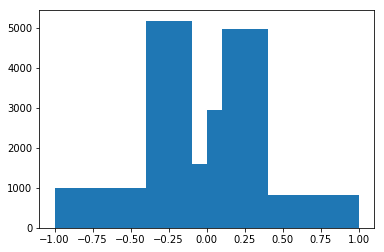

In [16]:
X_train, X_test, y_train, y_test = train_test_split(images, steer, test_size = 0.2, random_state = 0)

train_data = data_generator(X_train, y_train)
batch_x, batch_y = next(train_data)
print(batch_y)
batch_x, batch_y = next(train_data)
print(batch_y)

plt.hist(y_train, bins = [-1,-0.4,-0.1,0,0.1,0.4,1])
"""
X = np.zeros(shape = (len(X_train), row_size, col_size, 3))
for i in range(len(X_train)):
    img = mpimg.imread(X_train[i])
    img = img/255 - 0.5
    X[i] = crop(img)
Xtest = np.zeros(shape = (len(X_test), row_size, col_size, 3))
for i in range(len(X_test)):
    img = mpimg.imread(X_test[i])
    img = img/255 - 0.5
    Xtest[i] = crop(img)
"""

[ 0.          0.25        0.05219137  0.         -0.17867156  0.0974789   0.
 -0.29076847 -0.1409546  -0.1595345   0.01391724 -0.0638492   0.
 -0.33824026 -0.06925154 -0.25       -0.25        0.25        0.25
 -0.333864   -0.2686331   0.25        0.22234569  0.3009732  -0.25
  0.16175974  0.25        0.2052879  -0.29076847 -0.2306556  -0.149966
 -0.0829862  -0.2876218   0.3787396   0.25       -0.25       -0.3029152
 -0.25        0.22822024  0.25434871 -0.25       -0.00279104  0.          0.3404655
 -0.20737716  0.1712541  -0.4996443   0.3787396   0.         -0.0734177
  0.25        0.27348577 -0.0787459  -0.1308289  -0.357229    0.25
 -0.1177561  -0.03127411 -0.3952064   0.25       -0.25       -0.25
 -0.1610484  -0.25       -0.33354396  0.25       -0.25        0.25
 -0.27177976 -0.0829862   0.1333338  -0.19780863 -0.2959377   0.0617599
 -0.25       -0.3352022   0.0383331  -0.3287459   0.7136382  -0.7136382
  0.16175974 -0.3952064  -0.25        0.25       -0.25       -0.27765431
 -0.25 

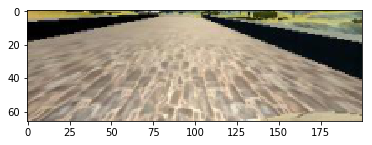

In [17]:
train_threshold=0.50
train_batch=data_generator(X_train,y_train,training=1,batch_size=128,threshold=train_threshold)

labels=[]
data=[]

try:
    count=0
    while 1:
        batch_x,batch_y=next(train_batch)
        
        if count==0:                        
            plt.imshow(batch_x[1].astype(np.uint8))
            
        count=count+1
        
        labels.append(batch_y)
        data.append(batch_x)
        
except StopIteration:
    pass

train_labels=np.concatenate( labels, axis=0 )

print(batch_y)

samples_per_epoch = len(train_labels)
print("len(train_labels)=",len(train_labels))



len(train_labels)= 4380


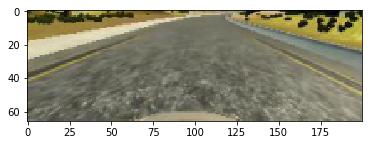

In [18]:
train_threshold=0.50
test_batch=data_generator(X_test,y_test,training=1,batch_size=128,threshold=train_threshold)

labels=[]
data=[]

try:
    count=0
    while 1:
        batch_x,batch_y=next(test_batch)
        
        if count==0:                        
            plt.imshow(batch_x[1].astype(np.uint8))
            
        count=count+1
        
        labels.append(batch_y)
        data.append(batch_x)
        
except StopIteration:
    pass

test_labels=np.concatenate( labels, axis=0 )

nb_val_samples = len(test_labels)

print("len(train_labels)=",len(test_labels))



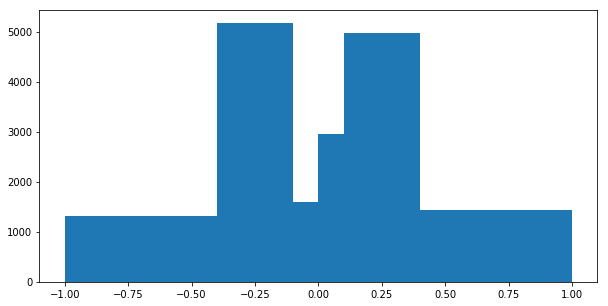

In [19]:
plt.figure(figsize=(10,5))
plt.hist(train_labels, bins = [-1, -0.4, -0.1, 0, 0.1, 0.4, 1])
plt.show()

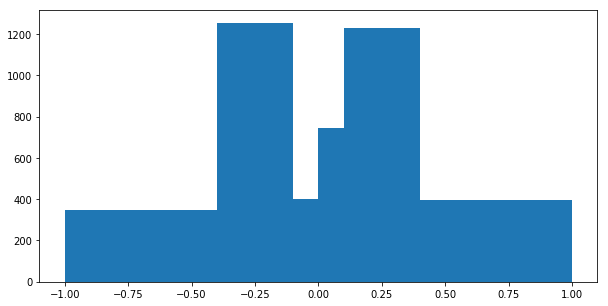

In [20]:
plt.figure(figsize=(10,5))
plt.hist(test_labels, bins = [-1, -0.4, -0.1, 0, 0.1, 0.4, 1])
plt.show()

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Input, Activation, Convolution2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
#model.add(Lambda(lambda x: x/255 - 0.5, input_shape=(row_size, col_size, 3)))

model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(row_size, col_size, 3)))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
model.add(Activation('relu'))

model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init="he_normal"))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init="he_normal"))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Activation('relu'))

model.add(Dense(100, init="he_normal"))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(50, init="he_normal"))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(10, init="he_normal"))
model.add(Activation('relu'))
model.add(Dense(1, init="he_normal"))

"""
model.add(Convolution2D(24, 5, 5, border_mode = 'valid', input_shape=(row_size, col_size, 3)))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(36, 5, 5))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Convolution2D(48, 5, 5))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(100))
model.add(Activation('elu'))
model.add(Dense(50))
model.add(Activation('elu'))
model.add(Dense(10))
model.add(Activation('elu'))
#model.add(Dropout(0.5))

model.add(Dense(1))
#model.add(Activation('softmax'))
"""

"\nmodel.add(Convolution2D(24, 5, 5, border_mode = 'valid', input_shape=(row_size, col_size, 3)))\nmodel.add(Activation('elu'))\n#model.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Convolution2D(36, 5, 5))\nmodel.add(Activation('elu'))\n#model.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.5))\nmodel.add(Convolution2D(48, 5, 5))\nmodel.add(Activation('elu'))\n#model.add(MaxPooling2D(pool_size = (2, 2)))\nmodel.add(Dropout(0.5))\nmodel.add(Convolution2D(64, 3, 3))\nmodel.add(Activation('elu'))\n#model.add(MaxPooling2D(pool_size = (2, 2)))\nmodel.add(Dropout(0.5))\nmodel.add(Convolution2D(64, 3, 3))\nmodel.add(Activation('elu'))\n#model.add(MaxPooling2D(pool_size = (2, 2)))\nmodel.add(Dropout(0.5))\n\nmodel.add(Flatten())\n\nmodel.add(Dense(100))\nmodel.add(Activation('elu'))\nmodel.add(Dense(50))\nmodel.add(Activation('elu'))\nmodel.add(Dense(10))\nmodel.add(Activation('elu'))\n#model.add(Dropout(0.5))\n\nmodel.add(Dense(1))\n#model.add(Activation('softmax'))\n"

In [25]:
model.summary()

'''
model.compile(optimizer='rmsprop',
          loss='binary_crossentropy',
          metrics=['accuracy'])
'''

model.compile(loss='mse',
              optimizer=Adam(lr = 0.001),
              metrics=['mean_squared_error'])
"""
history = model.fit(data_generator(X_train,y_train,training=0,batch_size=128),
                    samples_per_epoch=len(y_train),
                    validation_data=data_generator(X_test,y_test,training=0,batch_size=128),
                    nb_val_samples=len(y_test), nb_epoch=10, verbose=1)
"""
model.fit_generator(data_generator(X_train,y_train,training=0,batch_size=128, threshold = 0.5),
                    samples_per_epoch=samples_per_epoch,
                    validation_data=data_generator(X_test,y_test,training=0,batch_size=128, threshold = 0.5),
                    nb_val_samples=nb_val_samples,                    
                    nb_epoch=7,
                    verbose=2)
"""
model.fit_generator(datagen.flow(X, y_train, batch_size=128),
                    samples_per_epoch=len(X_train), validation_data = datagen.flow(Xtest, y_test, batch_size=128),
                    nb_val_samples = len(Xtest), nb_epoch = 15, verbose = 2)
"""

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 66, 200, 3)    0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_2[0][0]                   
____________________________________________________________________________________________________
activation_9 (Activation)        (None, 31, 98, 24)    0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 14, 47, 36)    21636       activation_9[0][0]               
___________________________________________________________________________________________

'\nmodel.fit_generator(datagen.flow(X, y_train, batch_size=128),\n                    samples_per_epoch=len(X_train), validation_data = datagen.flow(Xtest, y_test, batch_size=128),\n                    nb_val_samples = len(Xtest), nb_epoch = 15, verbose = 2)\n'

In [26]:
model.save('model.h5')

In [2]:
#reading in an image
log = pd.read_csv('driving_log.csv')
X = []
print(len(log))
for n in range(100):
    img = mpimg.imread(log.ix[n][0][27:])
    left = mpimg.imread(log.ix[n][1][28:])
    right = mpimg.imread(log.ix[n][2][28:])
    new = np.concatenate((np.concatenate((left,img), axis = 2), right), axis = 2)
    new = new/255 - 0.5
    X.append(new)
X = np.asarray(X)
X_val = X
print(X.shape)
Y = np.asarray(log.ix[:99,3])
Y_val = Y
print(Y.shape)

1861
(100, 160, 320, 9)
(100,)


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Input, Activation, Convolution2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode = 'valid', input_shape = (160, 320, 9)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('softmax'))

In [29]:
model.summary()

model.compile(optimizer='rmsprop',
          loss='binary_crossentropy',
          metrics=['accuracy'])
history = model.fit(X, Y, 
                    batch_size=32, nb_epoch=10, verbose=1, 
                    validation_data=(X_val,Y_val))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_10 (Convolution2D) (None, 158, 318, 32)  2624        convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
activation_13 (Activation)       (None, 158, 318, 32)  0           convolution2d_10[0][0]           
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 79, 159, 32)   0           activation_13[0][0]              
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 77, 157, 64)   18496       maxpooling2d_7[0][0]             
___________________________________________________________________________________________

KeyboardInterrupt: 